## Excel "What if?" analysis with Python - Part 1: Models and Data Tables


Excel is widely used for building and using models of business problems to explore the impact of various model inputs on key outputs. Built in "what if?" tools such as Excel [Data Tables](https://support.microsoft.com/en-us/office/calculate-multiple-results-by-using-a-data-table-e95e2487-6ca6-4413-ad12-77542a5ea50b) and [Goal Seek](https://support.microsoft.com/en-us/office/use-goal-seek-to-find-the-result-you-want-by-adjusting-an-input-value-320cb99e-f4a4-417f-b1c3-4f369d6e66c7) are well known to power spreadsheet modelers. How might we do similar modeling and analysis using Python? 

While Python has been gaining momentum in the business analytics world, it is often used for data wrangling, analysis and visualization of tablular data using tools like pandas and matplotlib or Seaborn. You can find some great examples at [Chris Moffit's Practical Business Python blog](https://pbpython.com/). I use Python all the time for such tasks and teach a course called [Practical Computing for Data Analytics](http://www.sba.oakland.edu/faculty/isken/courses/mis5470_w21/) that is Python (and R) based. But, it got me to thinking. What about those things for which Excel is well suited such as building formula based models and doing sensitivity analysis on these models? What would those look like in Python?

For example, here's a high level screenshot of a model that I assign for homework in my [MIS 4460/5460 Business Analytics class]() (a spreadsheet based modeling class).
It's a really simple model in which we are selling a single product that we produce. There is a fixed cost to producing the product as well as a variable production cost per unit. We can sell the product for some price and we believe that demand for the product is related to the selling price through a power function. Let's assume for now that we have sufficient capacity to produce to demand and that all inputs are deterministic (we'll deal with simulating uncertainty later in this document).

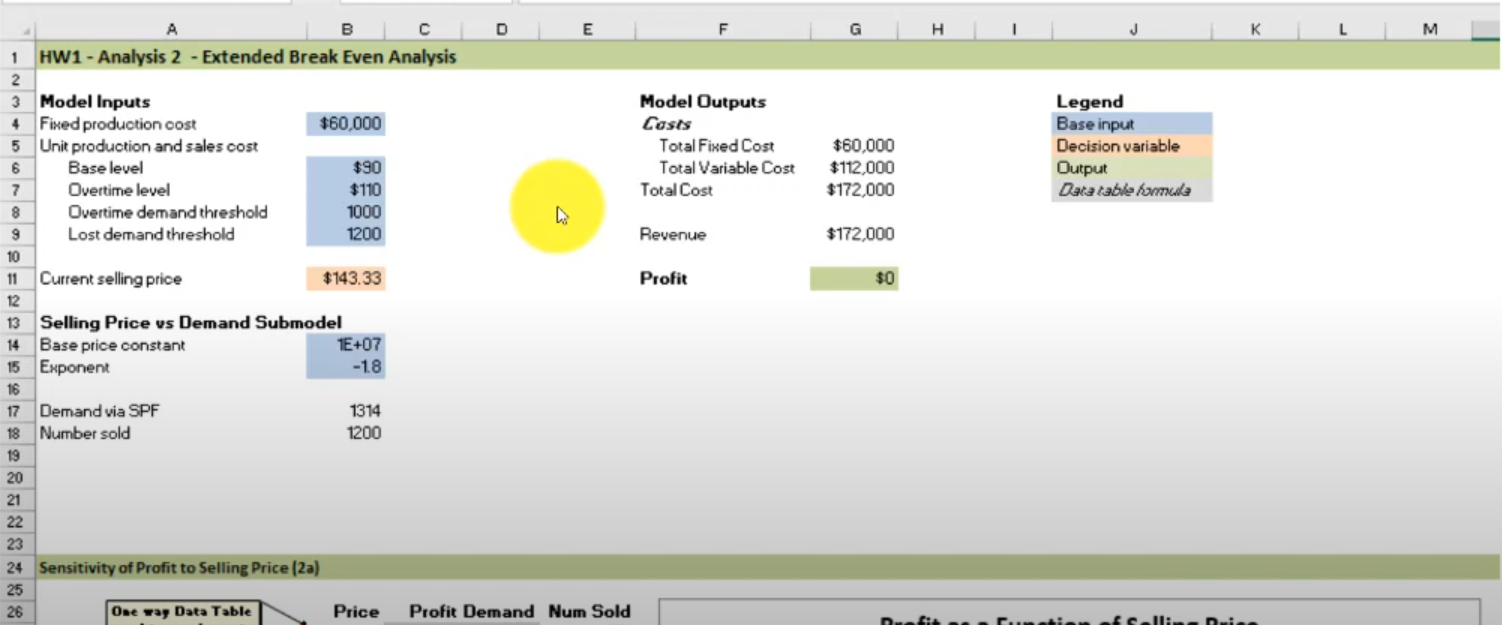

In [6]:
from IPython.display import Image
Image(filename='images/tech_sales_model.png')

The details aren't so important right now as is the overall structure of the model. There's a few key inputs and some pretty straightforward formulas for computing cost, revenue and profit. Notice the 1-way Data Table being used to explore how profit varies for different selling prices. There's a graph driven by the Data Table and some Text Boxes used for annotation and summary interpretative comments. There's a button that launches Goal Seek to find the break even selling price and a 2-way Data Table (not shown) to explore the joint effect of selling price and variable cost. Classic Excel modeling stuff. How might we go about building a similar model using Python?  

What if we wanted to push it a little further and model some of the key inputs with probability distributions to reflect our uncertainty about their values? In the Excel world, we might use add-ins such as @Risk which allow uncertain quantities to be directly modeled with probability distributions. For example, we might have a key input such as the exponent in the power function that relates selling price to demand that is highly uncertain. By modeling it with a probability distribution and then sampling from that distribution many times (essentially by recalcing the spreadsheet) we can generate a bunch of possible values for key outputs (e.g. profit) and use statistics to summarize these outputs using things like histograms and summary stats. Often this type of simulation model is referred to as a *Monte-Carlo* model to suggest repeated sampling from one or more probability distributions within an otherwise pretty static model. If you want to see such models in action, check out my [Simulation Modeling with Excel page](http://www.sba.oakland.edu/faculty/isken/courses/mis5460_w21/simulation.html) from my Business Analytics course. Again, how might we do this with Python?

In the remainder of this notebook (and subsequent follow on notebooks), we'll explore these questions and along the way introduce some basic object-oriented (OO) programming concepts and other slightly more advanced Python techniques. This is aimed at those who might have a strong Excel based background but only a basic familiarity with Python programming. We are going to use a slightly different problem example than the one I've discussed above (we'll save that one for an "exercise for the motivated reader"). I've structured things as follows:

**Part 1 - Models and Data Tables: this notebook**
* The bookstore problem
    - Non-OO model for the bookstore problem
    - 1-, 2-, n-way Data Tables with the non-OO model
* Everything is an object in Python
* An OO model for the bookstore problem
    - 1-, 2-, n-way data tables with the OO model
    

**Part 2 - Goal Seek: second notebook**
* Goal Seek
    - a non-OO hornet's nest
    - the OO approach

**Part 3 - Simulation: third notebook**
* Monte-Carlo simulation

**Part 4 - Create package: fourth notebook**
* share the results

**Part 5 - Simple GUI w/widgets: fifth notebook**



## Import some libraries
We'll need several Python libraries for this post. 

In [8]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [10]:
%matplotlib inline

## Bookstore model

This example is based on one in the [spreadsheet modeling textbook(s) I've used in my classes since 2001](https://host.kelley.iu.edu/albrightbooks/). I started out using Practical Management Science by Winston and Albright and switched to their Business Analytics: Data Analysis and Decision Making (Albright and Winston) around 2013ish. In both books, they introduce the "Walton Bookstore" problem in the chapter on Monte-Carlo simulation. Here's the basic problem (with a few modifications):

* we have to place an order for a perishable product (e.g. a calendar),
* there's a known unit cost for each one ordered,
* we have a known selling price,
* demand is uncertain but we can model it with some simple probability distribution,
* for each unsold item, we can get a partial refund of our unit cost,
* we need to select the order quantity for our one order for the year; orders can only be in multiples of 25.


### Base model - non-OO approach
Starting simple, let's create some initialized variables for the base inputs.

In [14]:
# Base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

Assume we've used historical data to estimate the mean and standard deviation of demand. Furthermore, let's pretend that a histogram revealed a relatively normal looking distribution. However, we are going to start by:

* assuming away the uncertainty,
* treat demand as deterministic using the mean,
* we'll do some sensitivity analysis to the demand.

Later, we'll use Monte-Carlo simulation with normally distribution demand.

In [17]:
# Demand parameters
demand_mean = 193
demand_sd = 40

# Deterministic model
demand = demand_mean

Finally, let's set the initial order quantity. This will be the variable we'll focus on in the sensitivity analysis (along with demand). Of course, if we pretend that we know demand is really equal to 193, then we'd only consider ordering 175 or 200 and would pick the one leading to higher profit. Let's set it to 200.

In [20]:
order_quantity = 200

Now we can compute the various cost and revenue components and get to the bottom line profit.

**QUESTION 1:** Complete the lines of code below (answer at bottom of notebook)

In [22]:
order_cost = unit_cost * order_quantity
sales_revenue = min(order_quantity, demand) * selling_price
refund_revenue = max(0, order_quantity - demand) * unit_refund
profit = sales_revenue + refund_revenue - order_cost

In [24]:
print(profit)

447.5


Of course, working in a Jupyter notebook is different than working in an Excel workbook. If we modify one of the base input values, the value of `profit` is **not** going to magically update.

In [27]:
unit_cost = 8.00
print(profit)

447.5


We either need to:

* rerun the code cell up above that computes the cost, revenue and profit, 
* or make the unit cost change up above when we first initialized and rerun all the cells,
* or take a different approach...

Since it feels like we are going to want to compute profit for different combinations of base input values, it makes sense to create a function to compute it. We'll do that eventually, but let's keep going with this simplistic approach for a bit longer and learn some things about working with vectors.

In [30]:
# Reset entire model

# Base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
demand = 193
order_quantity = 200

# Intermediate variables
order_cost = unit_cost * order_quantity
sales_revenue = min(order_quantity, demand) * selling_price
refund_revenue = max(0, order_quantity - demand) * unit_refund

# Key output variable
profit = sales_revenue + refund_revenue - order_cost

message = f"{'Order Cost':15}{order_cost:10.2f} \n" \
          f"{'Sales Revenue':15}{sales_revenue:10.2f} \n" \
          f"{'Refund':15}{refund_revenue:10.2f} \n" \
          f"{'Profit':15}{profit:10.2f}"

print(message) 

Order Cost        1500.00 
Sales Revenue     1930.00 
Refund              17.50 
Profit             447.50


Notice we've used Python newish approach to formatting strings called [f-strings](https://realpython.com/python-f-strings/). See https://pyformat.info/ for the basics on the format specification (using examples comparing the old % style formatting versus the newer `str.format()` approach) or the [official docs for all the gory details](https://docs.python.org/3/library/string.html#format-specification-mini-language).

### Sensitivity analysis analogous to a 1-way Data Table

To compute `profit` for several different values of `order_quantity` in Excel, we could do a 1-way Data Table. 

In Python, we could set `order_quantity` equal to a vector and then recompute profit. Our model should spit out a vector of profit values corresponding to the order quantities in our `order_quantity` vector. The numpy function [arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) can be used to create the vector.

In [33]:
order_quantity = np.arange(start=50, stop=301, step=25)
print(order_quantity)

[ 50  75 100 125 150 175 200 225 250 275 300]


In [35]:
type(order_quantity)

numpy.ndarray

**QUESTION** Why do we set `stop=301` instead of 300? Also, what's the data type of `order_quantity`?

In [41]:
order_quantity.dtype

dtype('int32')

In [43]:
order_cost = unit_cost * order_quantity
sales_revenue = np.minimum(order_quantity, demand) * selling_price
refund_revenue = np.maximum(0, order_quantity - demand) * unit_refund
profit = sales_revenue + refund_revenue - order_cost
print(profit)

[125.  187.5 250.  312.5 375.  437.5 447.5 322.5 197.5  72.5 -52.5]


In [45]:
sales_revenue

array([ 500.,  750., 1000., 1250., 1500., 1750., 1930., 1930., 1930.,
       1930., 1930.])

We can't just use `min()`( with a scalar (`demand`) compared to a vector (`order_quantity`). Need to use numpy functions since they will do the necessary [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) of demand values to fill out a vector the same size as the `order_quantity` vector. In R, broadcasting is usually referred to as *recycling*.

In [48]:
np.minimum(order_quantity, demand)

array([ 50,  75, 100, 125, 150, 175, 193, 193, 193, 193, 193])

This won't work:

    min(order_quantity, demand)

    ---------------------------------------------------------------------------
    ValueError                                Traceback (most recent call last)
    <ipython-input-42-675af9b521e5> in <module>
    ----> 1 min(order_quantity, demand)

    ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Here's a simple plot to show how profit varies by order quantity.

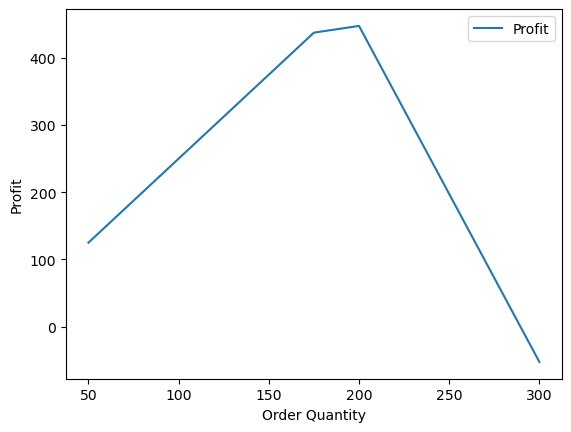

In [52]:
plt.plot(order_quantity, profit, label="Profit")
plt.xlabel('Order Quantity')
plt.ylabel('Profit')
plt.legend()
plt.show();

**QUESTION**
What about a 2-way Data Table? Why can't we just set one of the other inputs (e.g. demand) to a vector and do the same thing we did above?

One approach to creating a 2-way (actually, n-way) is to create a profit function that we can call from within a list comprehension.

In [56]:
def bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):
    '''
    Compute profit in bookstore model
    '''
    order_cost = unit_cost * order_quantity
    sales_revenue = np.minimum(order_quantity, demand) * selling_price
    refund_revenue = np.maximum(0, order_quantity - demand)
    profit = sales_revenue + refund_revenue - order_cost
    return profit

A [list comprehension](https://www.pythontutorial.net/python-basics/python-list-comprehensions/) can be used to create an n-way Data Table. List comprehensions provide a nice syntactical shortcut to creating a list based one looping over one or more iterables and computing associated values to store in the list. As a simple first example that's related to the model we are working on, let's compute the difference between demand and order quantity for all the combinations of those variables in the following ranges:

In [75]:
#np.arange(start number, stop number+1, interval)

demand_range = np.arange(50, 101, 10)
order_quantity_range = np.arange(50, 101, 25)
print(demand_range)
print(order_quantity_range)

[ 50  60  70  80  90 100]
[ 50  75 100]


Let's first use a list comprehension to list the combinations (we'll store each combo in a tuple). Each combination is a *scenario* for which we'd like to compute profit.

In [78]:
print([(d, o) for d in demand_range for o in order_quantity_range])

[(50, 50), (50, 75), (50, 100), (60, 50), (60, 75), (60, 100), (70, 50), (70, 75), (70, 100), (80, 50), (80, 75), (80, 100), (90, 50), (90, 75), (90, 100), (100, 50), (100, 75), (100, 100)]


This time I'll compute a list of differences between demand and order quantity.

In [81]:
print([d - o for d in demand_range for o in order_quantity_range])

[0, -25, -50, 10, -15, -40, 20, -5, -30, 30, 5, -20, 40, 15, -10, 50, 25, 0]


Here's a 2-way with demand and order quantity - the other inputs are held constant at their current values and the `bookstore_profit` function is used to compute profit. The list comprehension will generate a list of tuples, `(demand, order quantity, profit)`. To facilitate further analysis, we'll create a pandas DataFrame from this list.

Python tuples are a type of data structure that is very similar to lists. The main difference between the two is that tuples are immutable, meaning they cannot be changed once they are created. This makes them ideal for storing data that should not be modified, such as database records.

In [86]:
demand_range = np.arange(50, 301, 5)
order_quantity_range = np.arange(50, 301, 25)

In [88]:
# Create data table (as a list of tuples)
data_table_1 = [(d, oq, bookstore_profit(unit_cost, selling_price, unit_refund, oq, d)) 
                 for d in demand_range for oq in order_quantity_range]

# Convert to dataframe
dtbl_1_df = pd.DataFrame(data_table_1, columns=['Demand', 'OrderQuantity', 'Profit'])
dtbl_1_df.head(25)

,Demand,OrderQuantity,Profit
0,50,50,125.0
1,50,75,-37.5
2,50,100,-200.0
3,50,125,-362.5
4,50,150,-525.0
5,50,175,-687.5
6,50,200,-850.0
7,50,225,-1012.5
8,50,250,-1175.0
9,50,275,-1337.5


Here's a quick scatter plot showing how profit (mapped to color hue) varies jointly by order quantity and demand. No surprises.

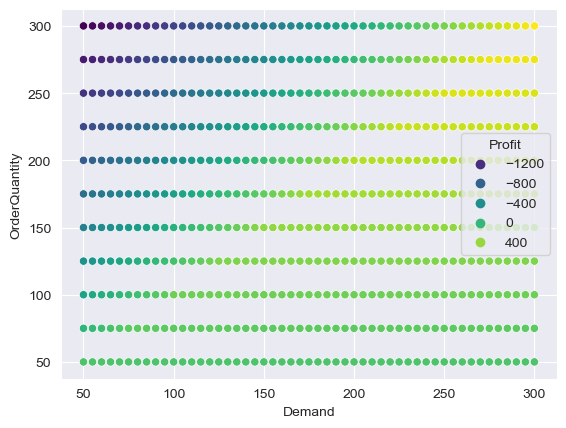

In [91]:
sns.set_style("darkgrid")
sns.scatterplot(x="Demand", y="OrderQuantity", hue="Profit", data=dtbl_1_df, palette="viridis");

For fun, let's try a 3d plot.

https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#mplot3d-tutorial

C:\Users\ahojd\AppData\Local\Temp\ipykernel_15516\3601524011.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(dtbl_1_df['OrderQuantity'], dtbl_1_df['Demand'], dtbl_1_df['Profit'],


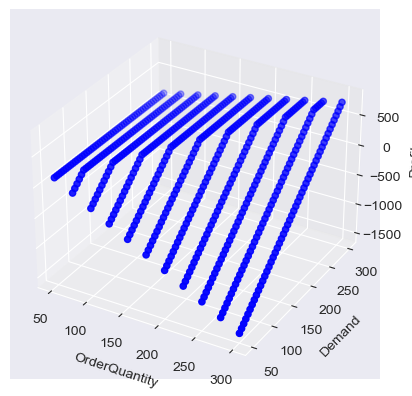

In [96]:
# Make the plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtbl_1_df['OrderQuantity'], dtbl_1_df['Demand'], dtbl_1_df['Profit'], 
                cmap=plt.cm.viridis, c='blue')

ax.set_xlabel('OrderQuantity')
ax.set_ylabel('Demand')
ax.set_zlabel('Profit')

plt.show();

https://github.com/pandas-dev/pandas/issues/53908

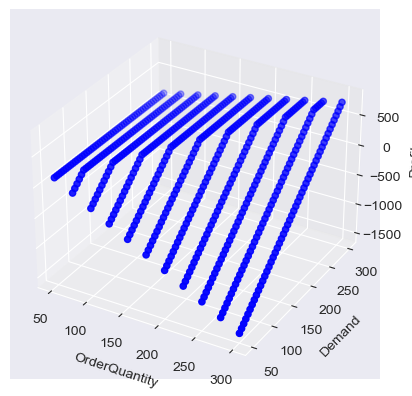

In [102]:
# Make the plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtbl_1_df['OrderQuantity'], dtbl_1_df['Demand'], dtbl_1_df['Profit'], 
                c='blue')

ax.set_xlabel('OrderQuantity')
ax.set_ylabel('Demand')
ax.set_zlabel('Profit')

plt.show();

## Everything is an object in Python
So far we have used standard procedural Python for creating and using our model. However, we want to explore using an object-oriented approach to doing the same things we just did. Before doing that, we need to review some basics regarding object-oriented programming.

Objects are the "things" we create, use, change and share in our Python programs. Objects contain both data about the object and functions for using and changing the object. If you've programmed in Excel VBA, you've already worked with objects and their various properties (data) and methods (functions). For example, consider a `Worksheet` object. One of its properties is `Name` and we can reference it with `Worksheet.Name`. To copy a worksheet, we use `Worksheet.Copy` - `Copy` is a method.

### List objects

In Python, everything is an object and we've already been using objects in this notebook. It's probably not surprising that something like an array or a list are objects. Let's see what kind of objects they are.

In [106]:
type(order_quantity_range)

numpy.ndarray

In [108]:
type(data_table_1)

list

Let's explore some list methods. To start, we will create a list based on the `order_quantity_range` and then do a few things with the new list.

In [115]:
oq_list = list(order_quantity_range)
print(oq_list)
print(type(oq_list))

[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
<class 'list'>


A Python `class` is the template from which we create individual objects, called *instances* in our programs. The `list` class lets us create list objects. Python has many built in classes with numerous predefined methods and properties. 

In [118]:
# Append a new item to end of list
oq_list.append(350)
print(oq_list)

[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350]


In [120]:
# Reverse the order of our list
oq_list.reverse()
print(oq_list)

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]


In [127]:
# Reverse it back
oq_list.reverse()
print(oq_list)

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]


Notice that when we use the `append` and `reverse` functions we need to include parentheses just as we do when calling any function. In this case, we aren't passing any arguments into the function, but often we will. 

In [130]:
# Use sort() method to do a reverse sort of our list
oq_list.sort(reverse=True)
print(oq_list)

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]


What if we forget the parentheses?

In [133]:
print(oq_list.reverse)

<built-in method reverse of list object at 0x00000191F20E3AC0>


Python just tells us that `reverse` is a function. It's also telling us that `reverse`, a function, is also an object. Yes, functions are objects, too. That means we can do things like pass them to other functions or modify some of their properties. Why would we ever want to do this? We'll get to that.

I'm sure you already know how to get items from a list by their index number.

In [138]:
# Get the first element from the list
print(oq_list[0])

350


The bracket notation is really just a convenient shorthand for calling one of the built in methods of list objects. We can use Python `dir` function to see all of the attributes of any object.

In [141]:
print(dir(oq_list))

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


Many of the attributes have both leading and trailing double underscores, known as "dunder" attributes. These are just special names reserved by Python for particular uses. In Python, you'll see use of both single and double underscores, as both leading and trailing characters. To dig deeper, check out https://dbader.org/blog/meaning-of-underscores-in-python.

In our example, using brackets to access a list item is really just a different way of calling the `__getitem__` dunder method.

In [144]:
print(oq_list.__getitem__(0))

350


Also notice that all of these functions worked *in place* - they operated directly on the object `oq_list` and even modified it for the sort related methods. Some methods will create a new instance of the object and if you want to "save" it, you'll have to assign the result back to your original object or create a new variable. If you've used R, you might recall that the dplyr package **never** modifies dataframes in place. The dplyr functions (e.g. `select`, `mutate`, `filter`, ...) always return new objects and we have to "catch the results" by assigning to a variable if we wanted to actually modify our dataframe.

Returning to our list example, we'll make a copy and explore a bit.

In [147]:
new_list = oq_list.copy()    # Make a copy and save to new variable
print(new_list)              # Check out the new variable
print(new_list == oq_list)   # Does the new variable have the same value as the old variable?
print(type(new_list) == type(oq_list))  # Are the two variables of the same type?
print(new_list is oq_list)   # Is the new variable actually the same object as the old variable?
print(id(oq_list), id(new_list))  # Every object has its own unique id number. Use id() to see it.

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]
True
True
False
1726342904512 1726343074880


The two lists have the same value and are of the same datatype, but are **not** the same object.

**QUESTION** If we reversed one of the two lists, would they still be considered to have the same value? In other words, does order matter with lists?

***Care must be taken when copying lists.***

In [150]:
print(oq_list)

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]


In [152]:
# Instead of using copy method, just setting new variable value equal to existing list
new_oq_list = oq_list 
print(new_oq_list)
oq_list.reverse() # I'm reversing the ORIGINAL list
print(new_oq_list)
print(id(oq_list), id(new_oq_list))

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]
[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350]
1726342904512 1726342904512


Yikes! As you can see from the `id` numbers, both list variables point to the same object in memory. Changing one list, changes the other - they're the same object. So, how do you safely copy lists? You use the `copy` method like we did above.

Let's look at the attributes of a `numpy.array` object and see how that compares to a list. They are both data structures that allow us to store a bunch of values and get at them via an index number. What differences do you think these two data structures might have?

In [160]:
dir(order_quantity_range)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__o

Wow, [numpy arrays](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html) have a whole lot more going on under the hood than do lists. They play a huge role in doing data science work in Python with many packages using numpy to store and work with data. Notice that there are various mathematical methods such as `sum` and `mean` and methods to convert arrays to lists and strings using the obviously named methods. We see that there is a `dtype` property - it tells us the data type of the array. Our array stores 64bit integers.

In [163]:
print(order_quantity_range.dtype)

int32


**QUESTIONS** Why don't we use parens with `dtype`? Why don't list objects have a `dtype` property?

### What about numbers?
Are things like integers and floating point numbers actually objects?

In [167]:
print(unit_cost)
print(type(unit_cost))
print(dir(unit_cost))

7.5
<class 'float'>
['__abs__', '__add__', '__bool__', '__ceil__', '__class__', '__delattr__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floor__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getformat__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__int__', '__le__', '__lt__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__pos__', '__pow__', '__radd__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmod__', '__rmul__', '__round__', '__rpow__', '__rsub__', '__rtruediv__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__trunc__', 'as_integer_ratio', 'conjugate', 'fromhex', 'hex', 'imag', 'is_integer', 'real']


In [169]:
unit_cost.is_integer()

False

In [171]:
unit_cost.hex()

'0x1.e000000000000p+2'

Yep. Try out some of the attributes.

### Writing our own classes
While Python has many useful built in classes, true [object-oriented programming](https://en.wikipedia.org/wiki/Object-oriented_programming) (OOP) involves creating our own classes from which we can create object instances that are useful for the problem at hand. Python is an OOP language but it does **not** force you to create classes if you don't want to. You can write any blend you'd like of [procedural](https://en.wikipedia.org/wiki/Procedural_programming), object oriented and [functional programming](https://en.wikipedia.org/wiki/Functional_programming). We aren't going to get into debates about which programming paradigm is the "best". There are times when OOP makes a lot of sense, and for those times, we'll use it. Other times, simply creating useful functions (such as the `bookstore_profit` function we used earlier) is the appropriate thing to do.

Many business analysts who learn Excel VBA, don't realize that **you can actually create classes in VBA**. Most stick with using the built in Excel objects.

## An OO version of the Bookstore Model

Let's create an OO version of the Bookstore Model and figure out how to do n-way data tables just as we did with the non-OO version of the model. Then we'll go on and figure out how to duplicate the functionality of Excel's Goal Seek tool in Python. It's not clear whether the non-OO or the OO version of our model will ultimately prove best for this use case. Regardless, we'll learn a few things along the way.

As an aside, there's a very useful site aimed at using Python for quantitative economics and finance - https://quantecon.org/. Within there are some terrific notebooks on various Python topics. Here are two related to OOP:

* https://python-programming.quantecon.org/oop_intro.html
* https://python-programming.quantecon.org/python_oop.html

### Initial design of the BookstoreModel class
It seems like we would want all of the base inputs such as unit cost, selling price, unit refund, order quantity and demand to be attributes (properties) of the class. Here's the start of our class definition code:

In [178]:
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand

Some important things of note:

* we use the keyword `class` followed by the name of our class.
* by convention, class names are capitalized (each word if multi-word).
* the class declaration looks a little like defining a function but we use `class` instead of `def`.
* there's nothing in the parentheses following the class name. We'll defer talking about this for now.
* there's a single method (function) defined within the class and it is called `__init__`. From earlier in this document we know that this must be a built in dunder method that has some special purpose. From its name you've probably already guessed that it's the function called when a new object instance is first created. If you've programmed in Java or C++, this is kind of like a constructor.
* the first argument to the `__init__` function is `self` and represents the object instance being created.
* the remaining arguments to the `__init__` function are values that we want to use in the function. In this case, we simply want to create object properties corresponding to the base inputs for the bookstore model.
* the rest of the lines within the `__init__` function are initializing our object properties to the values passed in. 
* in order to reference (i.e. to get the value or set the value) an object property, we always preface the property with the `self` object, e.g., `self.unit_cost`.
* if you've programmed in Java you might be used to using "setters and getters". In general [we don't do that in Python](https://www.python-course.eu/python3_properties.php) and instead just reference the property directly using dot notation.

Well, our class isn't super useful yet, but let's try it out. Make sure you run the code chunk above that defines the BookstoreModel class.

In [182]:
# Reset the base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
demand = 193
order_quantity = 200

# Create a new BookstoreModel object
model_1 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)

Let's print out one of the properties.

In [185]:
print(model_1.unit_cost)

7.5


What happens if we try to print the model object itself?

In [188]:
print(model_1)

Ok, not the most useful but we do see that we've got an object of the right type and that the object lives in the `__main__` *namespace*. Namespaces are important in Python. They're even mentioned in the Zen of Python. You can [learn more about namespaces here](https://realpython.com/python-namespaces-scope/).

In [191]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


If you look back at our `bookstore_profit` function, you'll see that it first computes the various cost and revenue components and then computes profit from that. So, it would seem useful to add some methods to our BookstoreModel class that computed these things.

In [194]:
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
    def order_cost(self):
        """Compute total order cost"""
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        """Compute revenue from refunds for unsold items"""
        return np.maximum(0, self.order_quantity - self.demand) * self.unit_refund
    
    def profit(self):
        '''
        Compute profit
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit

A few important things to note:
* we added four new object functions (methods)
* each method only takes the `self` object as an input argument. We don't pass in the properties such as `unit_cost` or `order_quantity`. We don't need to since `self` knows about these things via its properties. They are *encapsulated* within the object.
* within each method we have to use `self.someproperty` in our expressions
* the `profit` method calls some of the other methods and when it does, it prefaces the method with `self.` and follows it with empty parens. The `self` object is implicitly passed.
* each method returns a value
* each method has a simple docstring

Before we can test out our enhanced class, we need to run the code cell above and we need to create a new object instance based on the updated class definition.

In [197]:
# Create a new BookstoreModel object
model_2 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)

In [199]:
print(model_2.sales_revenue())
print(model_2.profit())

1930.0
447.5


It would nice to have a way to print out a succinct summary of a BookstoreModel object. Let's start by just listing out the properties. We can use the Python `vars` function to help. This StackOverflow post has some good info on getting a dictionary of object properties:

https://stackoverflow.com/questions/61517/python-dictionary-from-an-objects-fields

In [202]:
print(vars(model_2))

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


The Pythonic way for creating a string representation of an object is to implement a `__str__` dunder function for our object. This function needs to return a string. Notice that the `vars` function returns a dictionary. You can learn more about `__str__` and the related `__repr__` dunder functions at https://dbader.org/blog/python-repr-vs-str. In a nutshell, we use `__str__` to create "pretty" string representations of an object for our user and `__repr__` for an unambiguous string representation that includes the object type.

In [341]:
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
    def order_cost(self):
        """Compute total order cost"""
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        """Compute revenue from refunds for unsold items"""
        return np.maximum(0, self.order_quantity - self.demand) * self.unit_refund
    
    def profit(self):
        '''
        Compute profit
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
    
    def __str__(self):
        """
        String representation of bookstore inputs
        """
        return str(vars(self))

Notice we wrapped `vars` with `str` to convert the dictionary to a string.

In [344]:
# Reset the base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
demand = 193
order_quantity = 200

# Create a new BookstoreModel object
model_3 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)

In [346]:
print(model_3)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [348]:
print(model_3.__str__())

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


**CHALLENGE 1** Modify the `__str__` function so that it also shows the computed value of `order_cost`, `sales_revenue`, `refund_revenue` and `profit`.

**CHALLENGE 2** Add a `lost_sales` method to the `BookstoreModel` class that returns the number of units that we could not sell because we didn't order enough.

In [325]:
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
    def order_cost(self):
        """Compute total order cost"""
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        """Compute revenue from refunds for unsold items"""
        return np.maximum(0, self.order_quantity - self.demand) * self.unit_refund
    
    def profit(self):
        '''Compute profit'''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
    
    def lost_sales(self):
        '''Compute number of units that we could not sell because we didn't order enough'''
        return np.maximum(0, self.demand - self.order_quantity)
    
    def __str__(self):
        """
        String representation of bookstore inputs
        """
        return f"Unit Cost: {self.unit_cost}, Selling Price: {self.selling_price}, Unit Refund: {self.unit_refund}, Order Quantity: {self.order_quantity}, Demand: {self.demand}, Order Cost: {self.order_cost()}, Sales Revenue: {self.sales_revenue()}, Refund Revenue: {self.refund_revenue()}, Profit: {self.profit()}"

In [327]:
# Reset the base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
demand = 200
order_quantity = 250

# Create a new BookstoreModel object
model_3a = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)

In [329]:
print(vars(model_3a))

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 250, 'demand': 200}


In [331]:
print(model_3a.__str__())

Unit Cost: 7.5, Selling Price: 10.0, Unit Refund: 2.5, Order Quantity: 250, Demand: 200, Order Cost: 1875.0, Sales Revenue: 2000.0, Refund Revenue: 125.0, Profit: 250.0


In [333]:
print(model_3a.lost_sales())

0


### 1-way Data Table with OO model
It seems entirely plausible that we could simply set one of the inputs to an array of values and then call the `profit` method.

In [350]:
# Set property equal to an array
model_3.order_quantity = np.arange(50, 301, 25)
model_3.order_quantity

array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300])

In [352]:
# Can we compute an array of profits? Try it.
model_3.profit()

array([125. , 187.5, 250. , 312.5, 375. , 437.5, 447.5, 322.5, 197.5,
        72.5, -52.5])

What about a 2-way data table using the OO model? We can't use the same direct array passing approach because of ...

In [355]:
# This won't work unless the two arrays are the same size - can't broadcast.
# Also, even if same size, doesn't do all combinations, just aligned elements.
demand_range = np.arange(70, 321, 5)
order_quantity_range = np.arange(70, 321, 10)    # Broadcast error
# order_quantity_range = np.arange(70, 321, 5)   # Doesn't do all combinations

# Method 1: Set property equal to an array
model_3.demand = demand_range
model_3.order_quantity = order_quantity_range

# model_3.profit()  # This line will trigger the broadcast error

Recall that for the non-OO model, we could easily do an n-way data table using a list comprehension that made use of the `bookstore_profit` function because we could explicitly loop over ranges of any subset of the input variables and call the `bookstore_profit` function with all of the input arguments specified. We can't do that with the OO model because the `profit` function is a method of the object and we don't pass it any input arguments other than `self`. So, we need a way to loop over all the input ranges and update the bookstore model object's input attributes and then call the `profit` method.

What to do?

### A decision point in our software design process
An end user modeler analagous to your basic Excel power user isn't going to write OO code to do a Data Table. The list comprehension approach based on a global function (i.e. the non-OO model) is much more likely. However, a relatively generic Data Table function could be implemented in an OO way and be quite reusable. Also, we still want to implement Goal Seek and it's not clear whether the OO or non-OO approach makes the most sense.

Well, let's forge ahead and design and create a Python based Data Table function that accepts an OO BookstoreModel object as one of its inputs. Surely, we'll learn some things along the way.

#### Adding an `update` method
Since were are going to need to repeatedly update some subset of the input parameters, let's add an `update` method to the BookstoreModel class that takes a dictionary of property, value pairs. The question is, **how do we update object attributes from a dictionary specifying the attribute and the new value?**

This StackoverFlow post was quite helpful:

https://stackoverflow.com/questions/2466191/set-attributes-from-dictionary-in-python

The idea is that we use Python's `setattr` function. Using [`setattr`](https://www.w3schools.com/python/ref_func_setattr.asp) is really easy:

    setattr(object, attribute name, attribute value)
    
As a specific example, it can be used like this.

In [360]:
model_4 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)
print(model_4)

# We want to update a existing model object with these parameter values
new_params = {'unit_cost': 8.5, 'order_quantity': 250}

# Iterate over the keys in new_params
for key in new_params:
            setattr(model_4, key, new_params[key])
        
print(model_4)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}
{'unit_cost': 8.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 250, 'demand': 193}


Okay, here's our updated BookstoreModel class. Note that I've changed to keyword arguments with default values.

In [365]:
class BookstoreModel():
    def __init__(self, unit_cost=0, selling_price=0, unit_refund=0, 
                 order_quantity=0, demand=0):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
        
    def update(self, param_dict):
        """
        Update parameter values
        """
        for key in param_dict:
            setattr(self, key, param_dict[key])
        
    def order_cost(self):
        """Compute total order cost"""
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        """Compute revenue from refunds for unsold items"""
        return np.maximum(0, self.order_quantity - self.demand) * self.unit_refund
    
    def profit(self):
        '''
        Compute profit in bookstore model
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
       
    def __str__(self):
        """
        Print dictionary of object attributes but don't include an underscore as first char
        """
        #return str(vars(self))
        return str({key: val for (key, val) in vars(self).items() if key[0] != '_'})

Let's try out our `update` method. Also, since now the BookstoreModel class uses keyword arguments with defaults, I'm going to create a new model object in a slightly different way:

* create a new model object and just take the zero default values for the input attributes
* use the `update` method to set the input attributes via a dictionary

In [368]:
base_inputs = {'unit_cost': 7.50,
              'selling_price': 10.00,
              'unit_refund': 2.50,
              'order_quantity': 200,
              'demand': 193}

model_5 = BookstoreModel()
model_5.update(base_inputs)
print(model_5)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


#### How to generate and iterate over scenarios to create a 2-way Data Table?
Let's regroup and remind ourselves where we are in the development process for our 2-way data table function. We've got two input variables, `demand` and `order_quantity` and we'd like to specify a range over which each variable should vary. Then, we want to consider all combinations of these variable values and compute the associated, say, profit (really, any ouput of our model). It would be convenient to be be able to specify our input ranges with a dictionary whose keys are the input variable names and the values are any valid Python iterable (such as a list or the output of some function that returns a range of values). For example:

In [371]:
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                   'order_quantity': np.arange(70, 321, 50)}

Our immediate goal is to convert this dictionary into a list of dictionaries - one dictionary per scenario. Like this:

    [{'demand': 70, 'order_quantity': 70},
     {'demand': 70, 'order_quantity': 120},
     {'demand': 70, 'order_quantity': 170},
     {'demand': 70, 'order_quantity': 220},
     {'demand': 70, 'order_quantity': 270},
     {'demand': 70, 'order_quantity': 320},
     {'demand': 95, 'order_quantity': 70},
     {'demand': 95, 'order_quantity': 120},
     ...
     ...
     ...
     {'demand': 320, 'order_quantity': 220},
     {'demand': 320, 'order_quantity': 270},
     {'demand': 320, 'order_quantity': 320}]
     
Each of these component dictionaries is something we can use with our new model object `update` method to set the corresponding values for each scenario. Hmmm, feels like some clever iterating and zipping and more iterating. Before doing that ourselves, can we do this using the functionality of some existing Python library? Spoiler alert, yes, we can.

#### Learning from the ideas and code from scikit-learn

[Scikit-learn](https://scikit-learn.org/stable/index.html) is an extremely popular Python package for building, testing and using machine learning models. In thinking about the input values for an n-way data table, it feels similar to a [parameter grid for a hyperparameter grid search in scikit learn](https://scikit-learn.org/stable/modules/grid_search.html). Can we borrow some of their patterns or code ideas?

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

Example from User Guide shows passing in two different grids to explore as a list of dicts. Notice that each dict is like the setup for an Excel Data Table - the key is just the name of some variable and the value is some iterable. Don't worry about the details, just look at the structure of `param_grid`.

    param_grid = [
      {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
     ]
     
For example, the `GridSearchCV` takes an estimator object and a parameter grid object. The parameter grid is a dict or list of dicts in which the keys are the parameter names. SKLearn implements a `ParameterGrid` class. Looking at its source, the docstring contains the following example. Notice that the result of `ParameterGrid(param_grid)` is a list of dicts in which each dict contains a specific combination of the parameter values, i.e., it generates all the scenarios to explore. 

    Examples
    --------
    >>> from sklearn.model_selection import ParameterGrid
    >>> param_grid = {'a': [1, 2], 'b': [True, False]}
    >>> list(ParameterGrid(param_grid)) == (
    ...    [{'a': 1, 'b': True}, {'a': 1, 'b': False},
    ...     {'a': 2, 'b': True}, {'a': 2, 'b': False}])
    True
    

Hmm, we could use this class directly.

In [375]:
from sklearn.model_selection._search import ParameterGrid

In [377]:
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                   'order_quantity': np.arange(70, 321, 50)}

In [379]:
dt_param_grid = list(ParameterGrid(dt_param_ranges))
print(dt_param_grid)

[{'demand': 70, 'order_quantity': 70}, {'demand': 70, 'order_quantity': 120}, {'demand': 70, 'order_quantity': 170}, {'demand': 70, 'order_quantity': 220}, {'demand': 70, 'order_quantity': 270}, {'demand': 70, 'order_quantity': 320}, {'demand': 95, 'order_quantity': 70}, {'demand': 95, 'order_quantity': 120}, {'demand': 95, 'order_quantity': 170}, {'demand': 95, 'order_quantity': 220}, {'demand': 95, 'order_quantity': 270}, {'demand': 95, 'order_quantity': 320}, {'demand': 120, 'order_quantity': 70}, {'demand': 120, 'order_quantity': 120}, {'demand': 120, 'order_quantity': 170}, {'demand': 120, 'order_quantity': 220}, {'demand': 120, 'order_quantity': 270}, {'demand': 120, 'order_quantity': 320}, {'demand': 145, 'order_quantity': 70}, {'demand': 145, 'order_quantity': 120}, {'demand': 145, 'order_quantity': 170}, {'demand': 145, 'order_quantity': 220}, {'demand': 145, 'order_quantity': 270}, {'demand': 145, 'order_quantity': 320}, {'demand': 170, 'order_quantity': 70}, {'demand': 170, 

Perfect! We have a list of dictionaries, each of which contains one of the combinations of the `demand` and `order_quantity` attributes that we want in our data table. Isn't it nice that we just implemented an `update` method that takes just such a dictionary as its input. Almost like we planned it. :)

While there's nothing wrong with leveraging the skikit-learn library for this task (after all, reusing objects is one of the whole reasons for OOP), we really don't need all the generality provided by its `ParameterGrid` class. We just need to do some careful iteration through our dictionary of input ranges to create the same output. It will give us a chance to use the very useful [itertools library](https://docs.python.org/3/library/itertools.html) and see Python's `zip` function in action. 

In [382]:
from itertools import product

In [384]:
# Look at the key, value pairs (tuples) in dt_param_ranges dictionary
dt_param_ranges.items()

dict_items([('demand', array([ 70,  95, 120, 145, 170, 195, 220, 245, 270, 295, 320])), ('order_quantity', array([ 70, 120, 170, 220, 270, 320]))])

Now we can use [unpacking](https://docs.python.org/3.6/tutorial/controlflow.html#unpacking-argument-lists) along with the [zip function](https://www.w3schools.com/python/ref_func_zip.asp) to get two tuples. One tuple will get stored in the variable `keys` and the other in `values`.

In [387]:
print("The original tuples")
print(*dt_param_ranges.items())
print("\nThe zipped tuples")
keys, values = zip(*dt_param_ranges.items())
print(keys, values)

The original tuples
('demand', array([ 70,  95, 120, 145, 170, 195, 220, 245, 270, 295, 320])) ('order_quantity', array([ 70, 120, 170, 220, 270, 320]))

The zipped tuples
('demand', 'order_quantity') (array([ 70,  95, 120, 145, 170, 195, 220, 245, 270, 295, 320]), array([ 70, 120, 170, 220, 270, 320]))


Now we have a tuple of the keys, `('demand', 'order_quantity')` and a tuple containing the two arrays of associated values.

What we need next is a way to get all the combinations of the values in the two arrays. This is a perfect job for the `itertools.product` function. Here's a simple example of what `product` does.

In [390]:
colors = ['red', 'blue', 'green']
intensities = ['pale', 'bright']
for pair in product(intensities, colors):
    print(pair)

('pale', 'red')
('pale', 'blue')
('pale', 'green')
('bright', 'red')
('bright', 'blue')
('bright', 'green')


The `values` variable is a tuple (that needs unpacking) containing the two arrays for which we want the `product`. I'll turn the result into a list so we can see it. Try it without the list to see what you get.

In [397]:
print(values)

(array([ 70,  95, 120, 145, 170, 195, 220, 245, 270, 295, 320]), array([ 70, 120, 170, 220, 270, 320]))


In [399]:
print(list(product(*values)))

[(70, 70), (70, 120), (70, 170), (70, 220), (70, 270), (70, 320), (95, 70), (95, 120), (95, 170), (95, 220), (95, 270), (95, 320), (120, 70), (120, 120), (120, 170), (120, 220), (120, 270), (120, 320), (145, 70), (145, 120), (145, 170), (145, 220), (145, 270), (145, 320), (170, 70), (170, 120), (170, 170), (170, 220), (170, 270), (170, 320), (195, 70), (195, 120), (195, 170), (195, 220), (195, 270), (195, 320), (220, 70), (220, 120), (220, 170), (220, 220), (220, 270), (220, 320), (245, 70), (245, 120), (245, 170), (245, 220), (245, 270), (245, 320), (270, 70), (270, 120), (270, 170), (270, 220), (270, 270), (270, 320), (295, 70), (295, 120), (295, 170), (295, 220), (295, 270), (295, 320), (320, 70), (320, 120), (320, 170), (320, 220), (320, 270), (320, 320)]


Finally, we need to zip each of these tuples with the `keys` variable and turn the resulting tuple into a dictionary. Let's recall what it contains:

In [402]:
keys

('demand', 'order_quantity')

The `zip` function works like a zipper and pairs elements in the same position in our two tuples.

In [405]:
list(zip(keys, (70, 120)))

[('demand', 70), ('order_quantity', 120)]

... and it's easy to turn this into a dictionary (which is what we want).

In [408]:
dict(zip(keys, (70, 120)))

{'demand': 70, 'order_quantity': 120}

Ok, just put all these ideas together.

In [411]:
param_grid = []

keys, values = zip(*dt_param_ranges.items())

for scenario in product(*values):
    params = dict(zip(keys, scenario))
    param_grid.append(params)
        
print(param_grid)

[{'demand': 70, 'order_quantity': 70}, {'demand': 70, 'order_quantity': 120}, {'demand': 70, 'order_quantity': 170}, {'demand': 70, 'order_quantity': 220}, {'demand': 70, 'order_quantity': 270}, {'demand': 70, 'order_quantity': 320}, {'demand': 95, 'order_quantity': 70}, {'demand': 95, 'order_quantity': 120}, {'demand': 95, 'order_quantity': 170}, {'demand': 95, 'order_quantity': 220}, {'demand': 95, 'order_quantity': 270}, {'demand': 95, 'order_quantity': 320}, {'demand': 120, 'order_quantity': 70}, {'demand': 120, 'order_quantity': 120}, {'demand': 120, 'order_quantity': 170}, {'demand': 120, 'order_quantity': 220}, {'demand': 120, 'order_quantity': 270}, {'demand': 120, 'order_quantity': 320}, {'demand': 145, 'order_quantity': 70}, {'demand': 145, 'order_quantity': 120}, {'demand': 145, 'order_quantity': 170}, {'demand': 145, 'order_quantity': 220}, {'demand': 145, 'order_quantity': 270}, {'demand': 145, 'order_quantity': 320}, {'demand': 170, 'order_quantity': 70}, {'demand': 170, 

Voila! We've recreated the same output as `ParameterGrid` gave us.

> This little exercise underscores the value of knowing the basics of OOP if you are going to do analytics work in Python. Almost all of the main libraries that you'll encounter (e.g. pandas, matplotlib, scikit-learn) are written in OO fashion. So, in order for you to be able to peek into their source code, make sense of things, and maybe even borrow some code as we did, you need to understand the basics of OOP in Python.

### Creating the data_table function

Our plan is to create a function that takes three inputs:

* a model object such as `model_5`,
* a dictionary containing the input attributes and associated ranges for the data table such as `dt_param_ranges`,
* a list of outputs which are methods of the the model object; for example `['profit']`

Since we don't want the `data_table` function to modify our passed in model object, we'll create a copy of the model within the function. As we saw when copying list objects, we need to be careful when copying user defined objects. We'll create what is known as a *deep copy* using the `copy` library. Learn more about [shallow and deep copying here](https://docs.python.org/3/library/copy.html).

Then we'll generate our parameter grid. I like to think of each element in the parameter grid, e.g. `{'demand': 295, 'order_quantity': 270}`, as a *scenario*. We loop over all the scenarios in the grid, updating the model copy and computing the requested outputs. For each scenario, we'll end up with a dictionary containing both the inputs and outputs. For example, `{'demand': 295, 'order_quantity': 270, 'profit':405.0}`. Each such dictionary will get stored in a list and then at the very end our function will convert this list to a pandas DataFrame and return it.

Here's our first version. Take note of the use of `getattr` to indirectly call methods (e.g. `profit`) of the model.

In [415]:
# Demo of getattr for indirect method calling
getattr(model_5, 'profit')()

447.5

In [417]:
def data_table(model, scenario_inputs, outputs):
    '''Create n-inputs by m-outputs data table. 

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for computing outputs from inputs
    scenario_inputs : dict of str to sequence
        Keys are input variable names and values are sequence of values for each scenario for this variable.
    outputs : list of str
        List of output variable names

    Returns
    -------
    results_df : pandas DataFrame
        Contains values of all outputs for every combination of scenario inputs
    '''

    # Clone the model using deepcopy
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(scenario_inputs))
    
    # Create the table as a list of dictionaries
    results = []

    # Loop over the scenarios
    for params in dt_param_grid:
        # Update the model clone with scenario specific values
        model_clone.update(params)
        # Create a result dictionary based on a copy of the scenario inputs
        result = copy.copy(params)
        # Loop over the list of requested outputs
        for output in outputs:
            # Compute the output.
            out_val = getattr(model_clone, output)()
            # Add the output to the result dictionary
            result[output] = out_val
        
        # Append the result dictionary to the results list
        results.append(result)

    # Convert the results list (of dictionaries) to a pandas DataFrame and return it
    results_df = pd.DataFrame(results)
    return results_df

Okay, let's try it out. This time, I'll use *dictionary unpacking* to pass in the parameter values to our class.

* Create a dict called `base_inputs` with values to use in the model
* Then **base_inputs** will *unpack* the dictionary to key, value pairs that are used to specificy the keyword input arguments for out `BookstoreModel`.

In [420]:
# Create a dictionary of base input values

base_inputs = {'unit_cost': 7.5, 
               'selling_price': 10.0, 
               'unit_refund': 2.5, 
               'order_quantity': 200, 
               'demand': 193}

In [422]:
# Create a new model with inputs specified by base_inputs dict
model_6 = BookstoreModel(**base_inputs)
print(model_6)
model_6.profit()

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


447.5

In [424]:
# Specify input ranges for scenarios (dictionary)
# 1-way table
dt_param_ranges_1 = {'demand': np.arange(70, 321, 25)}

# 2-way table
dt_param_ranges_2 = {'demand': np.arange(70, 321, 25),
                     'order_quantity': np.arange(70, 321, 50)}

# Specify desired outputs (list)
outputs = ['profit', 'order_cost']

# Use data_table function to create 1-way data table
m6_dt1_df = data_table(model_6, dt_param_ranges_1, outputs)
m6_dt1_df

,demand,profit,order_cost
0,70,-475.0,1500.0
1,95,-287.5,1500.0
2,120,-100.0,1500.0
3,145,87.5,1500.0
4,170,275.0,1500.0
5,195,462.5,1500.0
6,220,500.0,1500.0
7,245,500.0,1500.0
8,270,500.0,1500.0
9,295,500.0,1500.0


In [426]:
# Use data_table function to create 2-way data table
m6_dt2_df = data_table(model_6, dt_param_ranges_2, outputs)
m6_dt2_df

,demand,order_quantity,profit,order_cost
0,70,70,175.0,525.0
1,70,120,-75.0,900.0
2,70,170,-325.0,1275.0
3,70,220,-575.0,1650.0
4,70,270,-825.0,2025.0
...,...,...,...,...
61,320,120,300.0,900.0
62,320,170,425.0,1275.0
63,320,220,550.0,1650.0
64,320,270,675.0,2025.0


Let's plot the 2-way results using Seaborn.

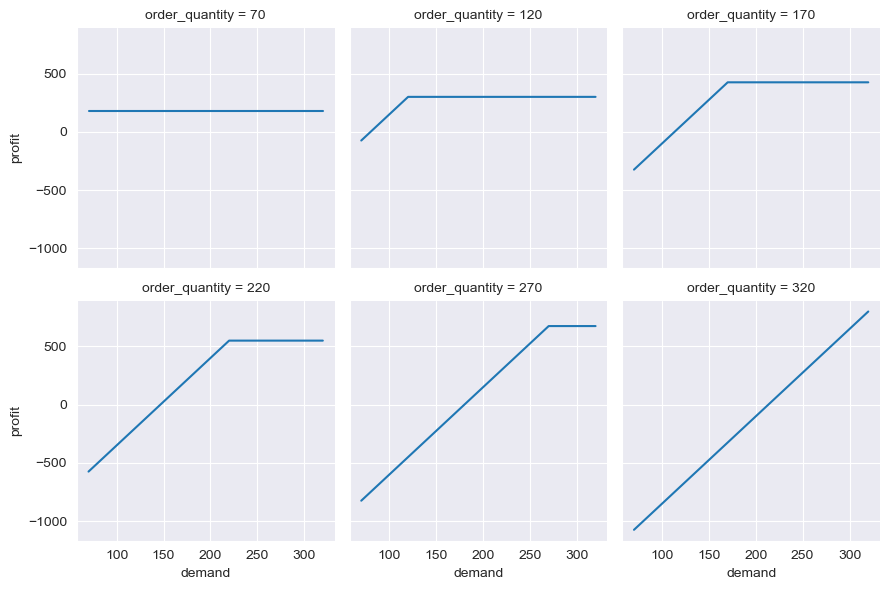

In [429]:
profit_dt_g = sns.FacetGrid(m6_dt2_df, col="order_quantity", sharey=True, col_wrap=3)
profit_dt_g = profit_dt_g.map(plt.plot, "demand", "profit")

Perfect! The plots make sense in that the order quantity acts as an upper limit on profit since we end up with unmet demand whenever demand exceeds our order quantity.

## Concluding thoughts and next steps
We've created an OO version of a simple spreadsheet type model that lends itself pretty well to the type of sensitivity analysis we would do with something like Excel's Data Table tool. Our Python `data_table` function actually allows *n* input variables and *m* output variables. In Excel, you can either do a $1xn$ (a one-way Data Table) or $2x1$ (a two-way Data Table).

Along the way we learned the basics of doing OOP in Python and a bunch of more advanced Python functions and techniques. While that might have seemed like a bunch of work, now we've got a reusable model object and reusable data table function that we can build on.

In the next post, we'll build on this work and take on implementing an Excel-style Goal Seek function in Python. We'll explore this using both the OO and the non-OO models. Each leads to some interesting challenges. Which approach do you think will end up being easier to use within a Python `goal_seek` function?

Then we'll use these same models for Monte-Carlo simulation. We'll be creating our own `simulate` function to add to the `data_table` and `goal_seek` functions that we created in the first and second parts of this series.

In the fourth post in this series, we'll learn to create a Python package containing our three "what-if?" functions so that we can share our work and easily use these functions in different notebooks or Python programs.

## ANSWERS

**QUESTION 1:** Complete the lines of code below (answer at bottom of notebook)

In [ ]:
order_cost = unit_cost * order_quantity
sales_revenue = min(order_quantity, demand) * selling_price
refund_revenue = max(0, order_quantity - demand) * unit_refund
profit = sales_revenue + refund_revenue - order_cost

**CHALLENGE 2** Lost sales method

We could add the following method to our `BookstoreModel` class.

In [ ]:
def lost_sales(self):
    """Compute number of items demanded but no inventory to sell"""
    return np.maximum(0, self.demand - self.order_quantity)